# Assing existence: a first step in isolating the complex
In this notebook we will take a look at what it means to "assess existence" (or, perhaps more precisely "assess causality") in IIT. Following the introduction given of the [postulate](link) and on the [unfolding page](link), we will explore the following concepts:

1) basic properties of the transition probability matrix (TPM)
2) what is meant by conditional independence of the units 
3) how to obtain constrained and unconstrained probabilities from the TPM
4) how to compute causal informativeness
5) how we can use the causal informativeness to assess existence in its most basic form

Let's go!

---
 
<img src="figures/Panel_1.jpg" width=500/>

Just as a reminder, this is the example system we will work with: it is constituted of three simple, binary units (A, B, and C), each one of which is activated according to a sigmoidal activation function. Its connectivity, together with the units own function, determines the subtrate's TPM---the basis for the mathematical formalism we use in IIT.

## Import packages
The first thing to do is import the packages we will need

In [2]:
import pyphi
from tutorial_functions import visualization as viz
from tutorial_functions import utils
import numpy as np


In [3]:
%load_ext blackcellmagic
%load_ext autoreload

%matplotlib inline
%autoreload 2

## Create the substrate
Next, let's use the built-in functionality of pyphi to create the substrate from figure 1 of [the IIT 4.0 paper](https://arxiv.org/abs/2212.14787)

In [4]:
# give names to the units
node_labels = ["A","B","C"]

# set the strength of connectivity between units
connectivity = np.array(
    [
        [-.2,0.7,0.2],
        [0.7,-.2,0.0],
        [0.0,-.8,0.2]        
    ]
)

# set the level of determinism for the units' activation function 
determinism = 4

# build the network
substrate = pyphi.network_generator.build_network(
    [pyphi.network_generator.ising.probability]*len(node_labels),
    connectivity,
    temperature=1/determinism,
    node_labels=node_labels
)

substrate.node_labels

NodeLabels(('A', 'B', 'C'))

### Inspect the substrate TPM
We can now simply inspect the TPM of the substrate and start exploring its properties

In [30]:
viz.substrate_state_by_state(substrate)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.17,0.02,0.56,0.08,0.03,0.00,0.11,0.02
1,0,0,0.00,0.00,0.49,0.01,0.00,0.00,0.49,0.01
0,1,0,0.01,0.48,0.01,0.33,0.00,0.10,0.00,0.07
1,1,0,0.00,0.00,0.06,0.44,0.00,0.00,0.06,0.44
0,0,1,0.44,0.06,0.00,0.00,0.44,0.06,0.00,0.00
1,0,1,0.07,0.00,0.10,0.00,0.33,0.01,0.48,0.01
0,1,1,0.01,0.49,0.00,0.00,0.01,0.49,0.00,0.00


---
Each of these numbers indicate the probability that the substrate will transition from an input state (left) to an output state (top).

For example, we can see that the substrate has about a 50% probability of transitioning to (0,1,0) if it was in state (1,0,0).

In [147]:
# select state transition to highlight
input_state = (1,1,1)
output_state = (0,1,1)

# Get the state-by-state TPM
TPM = utils.state_by_state_tpm(substrate)

# visualize it with the state transition probability highlighted
viz.highlight_transition_probability(TPM,input_state,output_state)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.169634,0.022957,0.563205,0.076222,0.034249,0.004635,0.113709,0.015389
1,0,0,0.000541,0.000015,0.486160,0.013284,0.000541,0.000015,0.486160,0.013284
0,1,0,0.013248,0.484871,0.008881,0.325019,0.002675,0.097894,0.001793,0.065620
1,1,0,0.000327,0.002416,0.059274,0.437982,0.000327,0.002416,0.059274,0.437982
0,0,1,0.437982,0.059274,0.002416,0.000327,0.437982,0.059274,0.002416,0.000327
1,0,1,0.065620,0.001793,0.097894,0.002675,0.325019,0.008881,0.484871,0.013248
0,1,1,0.013284,0.486160,0.000015,0.000541,0.013284,0.486160,0.000015,0.000541


We can also get at this conditional probability, by indexing into TPM directly

In [148]:
# Get probability 
P = TPM[output_state][input_state]

print('Probability of transitioning from {} to {} is {}'.format(
    input_state,output_state,P.round(3)
))

Probability of transitioning from (1, 1, 1) to (0, 1, 1) is 0.023


Given a particular input state, the output state it might bring about is rarely fully deterministic (the probability is rarely exactly 1).
Just to get an overview of the situation, it might be useful to see the way the probabilities are distributed across the possible output states.
This can easily be visualized by a bar chart:

<Axes: title={'center': 'Transition probabilities constrained to the input state (1, 1, 0)'}, xlabel='A,B,C', ylabel='transition probability'>

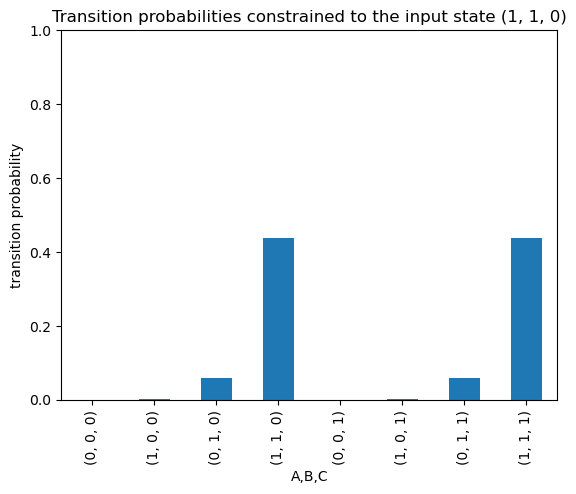

In [149]:
input_state = (1,1,0)
viz.constrained_repertoire(substrate, input_state)

As you may see from the name of the function above, we often refer to the conditional probabilities in the TPM as the *constrained probabilities*. This is because they indicate the probability of seeing a particular output state next, given (or constrained to the knowledge) that the input state was what it was. This is to contrast it to the *un*constrained probabilities (which we will see later), that tell us about the probabilities of observing some outputstate independently of what the input state was.  

You may notice that the TPM is normalized such that each row sums to exactly 1. This is because the substrate will necessarily transition to *some* state, whatever its starting point (input state) might be. In other words, the substrate has a 100% chance of transitioning to one of its available output states. 

In [36]:
TPM.sum(axis=1)

A  B  C
0  0  0    1.0
1  0  0    1.0
0  1  0    1.0
1  1  0    1.0
0  0  1    1.0
1  0  1    1.0
0  1  1    1.0
1  1  1    1.0
dtype: float64

## Conditional independence

While it might seem natural to look at this square "state-by-state" representation of the TPM, it hides a crucial fact about TPMs in IIT: the units are conditionally independent! This means that, given the knowledge of what the input state of a substrate was, the output state of each unit is *independent* of the output state of the other units. 

Lets explore this fact with the inbuilt functionality of pyphi.

In [150]:
# set an input state for the substrate
input_state = (1,0,0)

# print the values stored in the pyphi tpm when we provide it with the input state
substrate.tpm[input_state]

ExplicitTPM([0.02659699 0.99888746 0.5       ])

These numbers just represent the probability of each of the three units (A, B and C) bein ON in the output state. For example, if you choose the input state (1,0,0,), you will see that unit A (represented by the first number) is almost guaranteed to be OFF (because P(ON)=0.027, and P(OFF)=1-P(ON)). Similarly, unit B is almost guaranteed to be ON, and unit C is completely undetermined: it is 50/50 whether it turns ON or OFF. 
Thus, we can see that all three units are indeterministic (none of the values are exactly 0 or 1), and while it is not explicit in the numbers, there is no dependence between what state unit A (first number) happens to take on and which state the other units will take on; each unit will just update according to their own probability. 
---
Furthermore, you might notice that we can derive the exact probabilities we saw in the previous "state-by-state"-representation of the TPM by using multiplication of these probabilities. For example, the probability of the substrate's overall output state is ON, ON, ON is just equal to the product of the three probabilities above. This is a direct consequence of the conditional independence.

In [151]:
input_state = (1,0,1)
output_state = (1,1,1)
P_from_units = utils.substrate_probability_from_unit_probabilities(substrate,input_state, output_state)
P_from_units

0.01324847157151889

Just to make what happens here explicit: we just take the product of the individual unit's probabilities. There is no interaction (dependence) between the outcome states of the subtrate units, given that their input state are determined

In [152]:
P = substrate.tpm[input_state]
P_A_on = P[0]
P_B_on = P[1]
P_C_on = P[2]

P_ABC_on_on_on = P_A_on*P_B_on*P_C_on
P_ABC_on_on_on

0.01324847157151889

Compare this probability to the one we have from the state-by-state TPM

In [153]:

viz.highlight_transition_probability(TPM,input_state,output_state)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.169634,0.022957,0.563205,0.076222,0.034249,0.004635,0.113709,0.015389
1,0,0,0.000541,0.000015,0.486160,0.013284,0.000541,0.000015,0.486160,0.013284
0,1,0,0.013248,0.484871,0.008881,0.325019,0.002675,0.097894,0.001793,0.065620
1,1,0,0.000327,0.002416,0.059274,0.437982,0.000327,0.002416,0.059274,0.437982
0,0,1,0.437982,0.059274,0.002416,0.000327,0.437982,0.059274,0.002416,0.000327
1,0,1,0.065620,0.001793,0.097894,0.002675,0.325019,0.008881,0.484871,0.013248
0,1,1,0.013284,0.486160,0.000015,0.000541,0.013284,0.486160,0.000015,0.000541


They are identical! (except for some rounding issues in the visualization)

This is true for any combination of input and output states: the the conditional probabilities in the state-by-state (square) TPM are always found by taking the product of probabilities from the state-by-node TPM. try it out!

In [24]:

# choose some input and output states
input_state = (1,1,0)
output_state = (1,1,1)

# compute probaility of the ooutput state happening from both TPM representations
P_from_units = utils.substrate_probability_from_unit_probabilities(substrate, input_state, output_state)
P_from_statebystate = TPM[output_state][input_state]

# check if they are the same
print('P from units: {}, P from state-by-state: {}'.format(P_from_units.round(3),P_from_statebystate.round(3)))
print('Are they equal?: {}'.format(P_from_units == P_from_statebystate))

P from units: 0.438, P from state-by-state: 0.438
Are they equal?: True


In fact, it might be best to think of the TPM primarily in its state-by-node form. As that makes it easier to consider the units as conditionally independent. 

In [43]:
viz.substrate_state_by_node(substrate)

,,,A ON,B ON,C ON
A,B,C,,,
0,0,0,0.12,0.77,0.17
1,0,0,0.03,1.00,0.50
0,1,0,0.97,0.40,0.17
1,1,0,0.88,0.99,0.50
0,0,1,0.12,0.01,0.50
1,0,1,0.03,0.60,0.83
0,1,1,0.97,0.00,0.50
1,1,1,0.88,0.23,0.83


Each column in this TPM shows the probability of the corresponding (binary) unit turning *ON*. In fact, we might just as well consider each column independently as a "unit TPM" for its corresponding unit.  

In [44]:
viz.unit_state_by_node(substrate,'B')

,,,B ON
A,B,C,
0,0,0,0.77
1,0,0,1.00
0,1,0,0.40
1,1,0,0.99
0,0,1,0.01
1,0,1,0.60
0,1,1,0.00
1,1,1,0.23


The perceptive reader might have spotted that units A and C seem to be behaving a bit strangely: the values in their unit TPMs seem to repeat in a structured manner.

In [45]:
viz.unit_state_by_node(substrate,'C')

,,,C ON
A,B,C,
0,0,0,0.17
1,0,0,0.50
0,1,0,0.17
1,1,0,0.50
0,0,1,0.50
1,0,1,0.83
0,1,1,0.50
1,1,1,0.83


This is because it only receives inputs from two out of the three units in the substrate.

In [57]:
unit = 'C'
inputs = utils.possible_inputs(substrate, unit)
print('Unit {} appears to receive inputs from the following units: {}'.format(unit,inputs))

Unit C appears to receive inputs from the following units: ['A', 'C']


Still, it is useful to keep the full set of input states in the TPM, for completeness sake. But this might be a good thing to explore for the reader! Have a go at figuring out how you can reduce the TPM such that it only has input states that matter (make a difference) to the C :)

Let's move on to the next section.

## Constrained and unconstrained probabilities

We mentioned above that the raw probabilities in the TPM are *constrained* probabilities. They are called this because they are conditional on a particular state, and in that sense they are constrained by the input state. 

In contrast, it is also possible to find the *un*constrained probabilities. That is, the probabilities that a certain output state appears, *independently* of what the input state was. 

---
For example, you might ask, what is the probability of unit C turning ON, regardless of its input state?

In [88]:
unit = 'C'
output_state = 0
unconstrained_probability = utils.unconstrained_unit_probability(substrate,unit,output_state)
print('The unconstrained probability of finding unit {} in state {} is: {}'.format(unit,output_state,unconstrained_probability))

The unconstrained probability of finding unit C in state 0 is: 0.5


Explicitly, this probability is found by 
1) obtaining the unit TPM, 
2) finding the average probability of it being in the particular output state we are interested in 

In [89]:
unit_tpm = utils.unit_state_by_state_tpm(substrate,unit)
explicit_unconstrained_probability = unit_tpm[output_state].mean()
print('the unconstrained probability, found by averaging the unit TPM along the column with output state {} is: {}'.format(output_state,explicit_unconstrained_probability[output_state]))
viz.tpm_probabilities(unit_tpm)

the unconstrained probability, found by averaging the unit TPM along the column with output state 0 is: 0.5


,,C,"(0,)","(1,)"
A,B,C,,
0,0,0,0.17,0.83
1,0,0,0.50,0.50
0,1,0,0.17,0.83
1,1,0,0.50,0.50
0,0,1,0.50,0.50
1,0,1,0.83,0.17
0,1,1,0.50,0.50
1,1,1,0.83,0.17


So now we can find both the constrained and unconstrained probabilities for finding any of our units in any of its states.

In [99]:
# define states
input_state = (0,1,0)
output_state = (1,1,0)
unit_output_state = {label: state for label,state in zip(substrate.node_labels, output_state)}

# compute probabilities
unconstrained_probabilities = {
    unit: utils.unconstrained_unit_probability(substrate,unit,output_state)
    for (unit, output_state) in unit_output_state.items()
}
constrained_probabilities = {
    unit: utils.constrained_unit_probability(substrate,unit,input_state,output_state)
    for (unit, output_state) in unit_output_state.items()
}

print('unconstrained probabilities: {}'.format(unconstrained_probabilities))
print('constrained probabilities: {}'.format(constrained_probabilities))

unconstrained probabilities: {'A': 0.5, 'B': 0.5, 'C': 0.5}
constrained probabilities: {'A': 0.026596993576865957, 'B': 0.5986876601124518, 'C': 0.8320183851339245}


We now also have what we need to comput the constrained and unconstrained probabilities for any overall substrate state. Due to the requirement of conditional independence, all we need to do is to multiply together the constrained and unconstrained probabilities from individual units computed for the relevant states.

In [127]:
P_constrained_substrate_state = np.prod([p for p in constrained_probabilities.values()])
P_unconstrained_substrate_state = np.prod([p for p in unconstrained_probabilities.values()])

print(
    'For output state {} and input state {}, the constrained and unconstrained probabilities for the substrate is {} and {}, respectively.'
    .format(input_state,output_state,P_constrained_substrate_state,P_unconstrained_substrate_state)
)

For output state (0, 1, 0) and input state (0, 1, 1), the constrained and unconstrained probabilities for the substrate is 0.013248471571518934 and 0.125, respectively.


We can also simply compute these values directly with the following little functions (see utils.py)

In [128]:
input_state = (0,1,0)
output_state = (0,1,1)

P_constrained = utils.constrained_probability(substrate,output_state,input_state)
P_unconstrained = utils.unconstrained_probability(substrate,output_state)

print(
    'For output state {} and input state {}, the constrained and unconstrained probabilities for the substrate is {} and {}, respectively.'
    .format(input_state,output_state,P_constrained_substrate_state,P_unconstrained_substrate_state)
)

For output state (0, 1, 0) and input state (0, 1, 1), the constrained and unconstrained probabilities for the substrate is 0.013248471571518934 and 0.125, respectively.


And we might as well compute the constrained and unconstrained probabilities for all output states and input states

In [144]:
P_all_constrained = utils.all_constrained_probability(substrate)
P_all_unconstrained = utils.all_unconstrained_probability(substrate)

Here we can see that the constrained probabilities are identical to the original state-by-state TPM (within a tiny margin of error).

In [143]:
P_all_constrained.round(5)==TPM.round(5)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,True,True,True,True,True,True,True,True
1,0,0,True,True,True,True,True,True,True,True
0,1,0,True,True,True,True,True,True,True,True
1,1,0,True,True,True,True,True,True,True,True
0,0,1,True,True,True,True,True,True,True,True
1,0,1,True,True,True,True,True,True,True,True
0,1,1,True,True,True,True,True,True,True,True


And the unconstrained probabilites are just uniformely distributed. This is not always the case, but we would always find that every row in the "TPM-like" representation would be identical. This is because the unconstrained probabilities are *independent* of the input state. In other words, it should not depend on the input state. 

In [146]:
P_all_unconstrained

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
1,0,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
0,1,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
1,1,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
0,0,1,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
1,0,1,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
0,1,1,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125


## Computing informativeness

In [154]:
input_state = (0,1,0)
output_state = (0,1,1)

P_constrained = utils.constrained_probability(substrate,output_state,input_state)
P_unconstrained = utils.unconstrained_probability(substrate,output_state)

In [157]:
informativeness = np.log2(P_constrained/P_unconstrained)

In [158]:
informativeness

1.955671888167051

## Using informativeness to "assess existence"

In [92]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: bold; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: lightblue; color: black;'
}
TPM.style.set_table_styles([cell_hover, index_names, headers])

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.170000,0.023000,0.563000,0.076000,0.034000,0.005000,0.114000,0.015000
1,0,0,0.001000,0.000000,0.486000,0.013000,0.001000,0.000000,0.486000,0.013000
0,1,0,0.013000,0.485000,0.009000,0.325000,0.003000,0.098000,0.002000,0.066000
1,1,0,0.000000,0.002000,0.059000,0.438000,0.000000,0.002000,0.059000,0.438000
0,0,1,0.438000,0.059000,0.002000,0.000000,0.438000,0.059000,0.002000,0.000000
1,0,1,0.066000,0.002000,0.098000,0.003000,0.325000,0.009000,0.485000,0.013000
0,1,1,0.013000,0.486000,0.000000,0.001000,0.013000,0.486000,0.000000,0.001000
